2025-06-30 14:17:48.727213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751293068.922364      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751293068.984700      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751293192.155773      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training with SGD...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1751293197.438774      61 service.cc:148] XLA service 0x7f3280046350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751293197.439569      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751293197.776547      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/88 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1281 - loss: 2.8064

I0000 00:00:1751293202.205735      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.1491 - loss: 2.4150 - val_accuracy: 0.1019 - val_loss: 2.5964
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2279 - loss: 2.1334 - val_accuracy: 0.1004 - val_loss: 2.7474
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2745 - loss: 2.0250 - val_accuracy: 0.1636 - val_loss: 2.4656
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3132 - loss: 1.8839 - val_accuracy: 0.1334 - val_loss: 2.5815
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3202 - loss: 1.9097 - val_accuracy: 0.2296 - val_loss: 2.6553

Training with SGD_Nesterov...
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1387 - loss: 2.5650 - val_accuracy: 0.2267 - val_loss: 2.0739
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1687 - loss: 2.1010 - val_accuracy: 0.2669 - val_loss: 1.8958
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1793 - loss: 2.0913 - val_accura

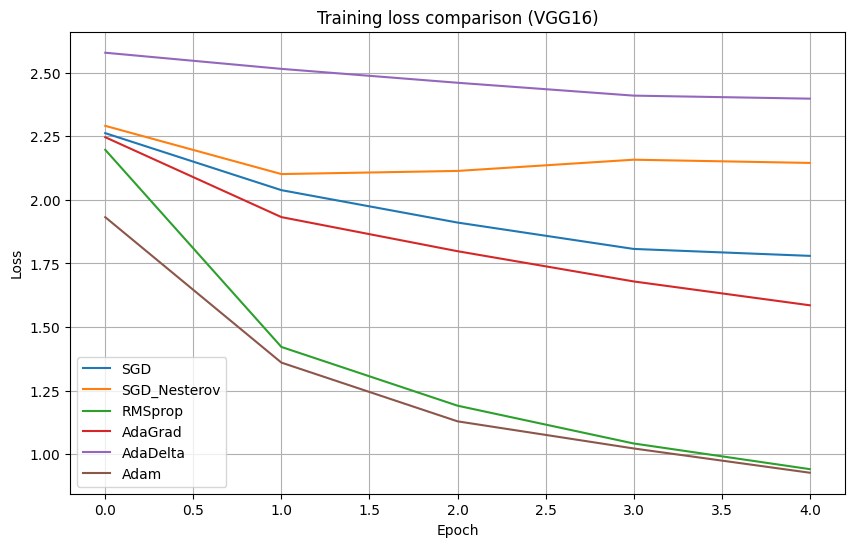

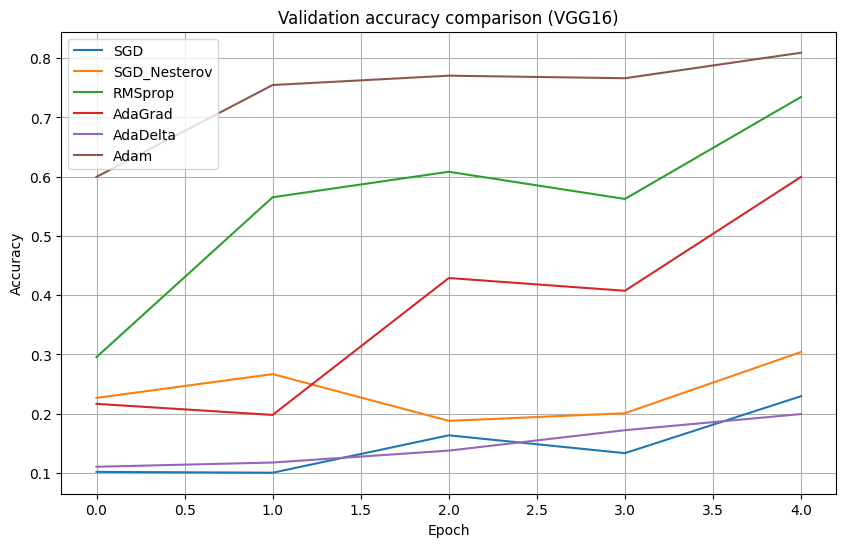

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# ======= Load dữ liệu custom =======
def load_dataset_from_dir(data_dir, img_size=(128, 128)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)))
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(cls_dir, fname))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float16) / 255.0
                X.append(img)
                y.append(cls)
    return np.array(X), np.array(y), classes

# Đường dẫn data của bạn (sửa lại nếu khác)
dataset_path_train = '/kaggle/input/cus-hand-written/hand_written_digit/train'
dataset_path_test = '/kaggle/input/cus-hand-written/hand_written_digit/test'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(128,128))
X_test, y_test, label_map_test = load_dataset_from_dir(dataset_path_test, img_size=(128,128))

le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.fit_transform(y_test)
num_classes = len(le.classes_)

# Chia tập train-valid tỉ lệ 8-2
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

# One-hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)

# ======= Hàm build model VGG16 + head mới =======
def build_vgg16_model(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False  # Đóng băng backbone

    x = Flatten()(vgg16.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=vgg16.input, outputs=output)
    return model

# ======= Danh sách optimizer cần so sánh =======
optimizers = {
    'SGD': SGD(),
    'SGD_Nesterov': SGD(nesterov=True, momentum=0.9),
    'RMSprop': RMSprop(),
    'AdaGrad': Adagrad(),
    'AdaDelta': Adadelta(),
    'Adam': Adam()
}

history_dict = {}

# ======= Huấn luyện từng optimizer =======
for opt_name, opt in optimizers.items():
    print(f"\nTraining with {opt_name}...")
    model = build_vgg16_model((128, 128, 3), num_classes)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_sub, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=32,
        epochs=5,
        verbose=1,
    )
    history_dict[opt_name] = history.history

print("✅ Training completed for all optimizers.")

# ======= Plot so sánh training loss =======
plt.figure(figsize=(10,6))
for opt_name, hist in history_dict.items():
    plt.plot(hist['loss'], label=opt_name)
plt.title('Training loss comparison (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ======= Plot so sánh validation accuracy =======
plt.figure(figsize=(10,6))
for opt_name, hist in history_dict.items():
    plt.plot(hist['val_accuracy'], label=opt_name)
plt.title('Validation accuracy comparison (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
